# Stage 2 v2: Model Training with Proper Targets

## Key Fix: Use ACTUAL Forward Returns

**Previous Issue:** Model was trained on `target_smooth` (EMA of returns) which has look-ahead bias.
- `target_smooth` correlates 0.75 with SAME-DAY `fwd_ret_1d`
- `target_smooth` has ZERO correlation with NEXT-DAY returns
- Predicting it well doesn't help trading!

**Fix:** Train on actual forward returns (`fwd_ret_5d`) cross-sectionally ranked.

## Pipeline
```
stage1_5_targets.parquet → [THIS NOTEBOOK] → stage2_v2_predictions.parquet
```

## Target: Cross-sectional rank of 5-day forward returns
- Less noisy than 1-day
- Proper forward-looking (no look-ahead bias)
- Cross-sectional ranking removes market beta

In [18]:
# ============================================================================
# IMPORTS AND CONFIGURATION
# ============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
import pickle
from pathlib import Path
from scipy import stats
from scipy.stats import spearmanr, pearsonr
from typing import Dict, List, Tuple, Optional
from datetime import datetime

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

try:
    import lightgbm as lgb
    HAS_LGBM = True
except ImportError:
    HAS_LGBM = False
    print("⚠️ LightGBM not installed")

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# Paths
BASE_DIR = Path.cwd().parent.parent
DATA_DIR = BASE_DIR / 'data'
PROCESSED_DIR = DATA_DIR / 'processed'
OUTPUT_DIR = BASE_DIR / 'outputs'
MODELS_DIR = OUTPUT_DIR / 'models'
FIGURES_DIR = OUTPUT_DIR / 'figures' / 'stage2_v2'

FIGURES_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Input/Output files
INPUT_FILE = PROCESSED_DIR / 'stage1_5_targets.parquet'
OUTPUT_FILE = PROCESSED_DIR / 'stage2_v2_predictions.parquet'
MODEL_DIAGNOSTICS_FILE = OUTPUT_DIR / 'stage2_v2_diagnostics.json'

# Configuration
IS_START = pd.Timestamp('2018-07-01')  # Start of available data
IS_END = pd.Timestamp('2023-12-31')
OOS_START = pd.Timestamp('2024-01-01')
OOS_END = pd.Timestamp('2026-12-31')

EMBARGO_DAYS = 5  # Gap between train and test
RETRAIN_FREQ = 21  # Retrain every month
TARGET_HORIZON = 5  # 5-day forward returns

print("="*70)
print(" STAGE 2 v2: MODEL TRAINING WITH PROPER TARGETS")
print("="*70)
print(f"Input: {INPUT_FILE}")
print(f"Output: {OUTPUT_FILE}")
print(f"Target Horizon: {TARGET_HORIZON} days")
print(f"IS Period: {IS_START.date()} to {IS_END.date()}")
print(f"OOS Period: {OOS_START.date()} to {OOS_END.date()}")

 STAGE 2 v2: MODEL TRAINING WITH PROPER TARGETS
Input: c:\Users\ponna\OneDrive\Desktop\Precog Task\data\processed\stage1_5_targets.parquet
Output: c:\Users\ponna\OneDrive\Desktop\Precog Task\data\processed\stage2_v2_predictions.parquet
Target Horizon: 5 days
IS Period: 2018-07-01 to 2023-12-31
OOS Period: 2024-01-01 to 2026-12-31


## 2.1 Load Data and Create Proper Target

In [2]:
# ============================================================================
# LOAD DATA
# ============================================================================
print("Loading data...\n")

df = pd.read_parquet(INPUT_FILE)
df['date'] = pd.to_datetime(df['date'])

print(f"Total rows: {len(df):,}")
print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"Tickers: {df['ticker'].nunique()}")

# Feature columns (z-scored features only)
feature_cols = [c for c in df.columns if '_zscore' in c and 'target' not in c]
print(f"Features: {len(feature_cols)}")
print(f"  Examples: {feature_cols[:5]}")

Loading data...

Total rows: 241,700
Date range: 2016-06-08 to 2026-01-16
Tickers: 100
Features: 38
  Examples: ['mom_5d_zscore', 'mom_10d_zscore', 'mom_21d_zscore', 'mom_acc_21d_zscore', 'mom_63d_zscore']


In [3]:
# ============================================================================
# CREATE PROPER FORWARD-LOOKING TARGET
# ============================================================================
print("Creating proper target variable...\n")

# Use 5-day forward returns
target_raw_col = f'fwd_ret_{TARGET_HORIZON}d'

if target_raw_col not in df.columns:
    print(f"Creating {target_raw_col}...")
    df[target_raw_col] = df.groupby('ticker')['Close'].transform(
        lambda x: x.shift(-TARGET_HORIZON) / x - 1
    )

# Cross-sectional z-score (removes market beta, focuses on relative ranking)
df['target'] = df.groupby('date')[target_raw_col].transform(
    lambda x: (x - x.mean()) / (x.std() + 1e-10)
)

# Winsorize extreme values
df['target'] = df['target'].clip(-3, 3)

print(f"Target: Cross-sectional z-score of {target_raw_col}")
print(f"  Range: [{df['target'].min():.2f}, {df['target'].max():.2f}]")
print(f"  Mean: {df['target'].mean():.4f}, Std: {df['target'].std():.4f}")

# Verify no look-ahead bias
print("\n🔍 Checking for look-ahead bias...")
sample = df[df.ticker == df.ticker.unique()[0]].sort_values('date')
# Target on day T should NOT correlate with returns on day T (that would be leak)
corr_same_day = sample['target'].corr(sample['fwd_ret_1d'])
# Target on day T SHOULD correlate somewhat with returns T+1 to T+5
corr_future = sample['target'].shift(TARGET_HORIZON).corr(sample['fwd_ret_1d'])
print(f"  Target vs same-day fwd_ret_1d: {corr_same_day:.4f} (should be ~0)")
print(f"  Target(t-{TARGET_HORIZON}) vs fwd_ret_1d(t): {corr_future:.4f}")

Creating proper target variable...

Target: Cross-sectional z-score of fwd_ret_5d
  Range: [-3.00, 3.00]
  Mean: -0.0032, Std: 0.9421

🔍 Checking for look-ahead bias...
  Target vs same-day fwd_ret_1d: 0.3485 (should be ~0)
  Target(t-5) vs fwd_ret_1d(t): -0.0028


In [5]:
# ============================================================================
# VERIFY TARGET PREDICTIVENESS
# ============================================================================
print("Verifying target has predictive signal...\n")

# Check if high target stocks actually outperform
def safe_qcut(x):
    try:
        return pd.qcut(x.rank(method='first'), 5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
    except:
        return pd.Series(['Q3'] * len(x), index=x.index)

df['quintile'] = df.groupby('date')['target'].transform(safe_qcut)

# Future returns by quintile (this IS what we're predicting)
q_rets = df.groupby(['date', 'quintile'])[target_raw_col].mean().unstack()
print(f"Average {TARGET_HORIZON}d returns by target quintile:")
print((q_rets.mean() * 100).round(4))

# Long-short spread
if 'Q5' in q_rets.columns and 'Q1' in q_rets.columns:
    spread = (q_rets['Q5'] - q_rets['Q1'])
    print(f"\nQ5-Q1 spread: {spread.mean()*100:.4f}% per {TARGET_HORIZON}d")
    print(f"Spread Sharpe: {spread.mean() / spread.std() * np.sqrt(252 / TARGET_HORIZON):.2f}")

# This should be high since target IS the quintile
# The model's job is to PREDICT which quintile each stock will be in

Verifying target has predictive signal...

Average 5d returns by target quintile:
quintile
Q1   -3.8370
Q2   -1.0382
Q3    0.3342
Q4    1.7062
Q5    4.7289
dtype: float64

Q5-Q1 spread: 8.5659% per 5d
Spread Sharpe: 22.29


## 2.2 Train/Test Split

In [6]:
# ============================================================================
# SPLIT DATA
# ============================================================================
print("Splitting data...\n")

# IS (In-Sample) and OOS (Out-of-Sample) masks
is_mask = (df['date'] >= IS_START) & (df['date'] <= IS_END)
oos_mask = (df['date'] >= OOS_START) & (df['date'] <= OOS_END)

is_df = df[is_mask].copy()
oos_df = df[oos_mask].copy()

print(f"IS data: {len(is_df):,} rows, {is_df['date'].nunique()} days")
print(f"   Date range: {is_df['date'].min().date()} to {is_df['date'].max().date()}")
print(f"OOS data: {len(oos_df):,} rows, {oos_df['date'].nunique()} days")
print(f"   Date range: {oos_df['date'].min().date()} to {oos_df['date'].max().date()}")

# Check for missing features
missing_features = [f for f in feature_cols if is_df[f].isna().all()]
if missing_features:
    print(f"\n⚠️ Dropping features with all NaN: {missing_features}")
    feature_cols = [f for f in feature_cols if f not in missing_features]

Splitting data...

IS data: 138,400 rows, 1384 days
   Date range: 2018-07-02 to 2023-12-29
OOS data: 51,300 rows, 513 days
   Date range: 2024-01-02 to 2026-01-16


## 2.3 Walk-Forward Model Training

In [7]:
# ============================================================================
# MODEL DEFINITIONS
# ============================================================================

def create_model(model_type: str, **params):
    """Factory function for model creation."""
    if model_type == 'ridge':
        return Ridge(alpha=params.get('alpha', 1.0))
    elif model_type == 'lasso':
        return Lasso(alpha=params.get('alpha', 0.01))
    elif model_type == 'elasticnet':
        return ElasticNet(alpha=params.get('alpha', 0.01), l1_ratio=0.5)
    elif model_type == 'lgbm' and HAS_LGBM:
        return lgb.LGBMRegressor(
            n_estimators=params.get('n_estimators', 100),
            max_depth=params.get('max_depth', 5),
            learning_rate=params.get('learning_rate', 0.05),
            num_leaves=params.get('num_leaves', 31),
            min_child_samples=params.get('min_child_samples', 50),
            reg_alpha=params.get('reg_alpha', 0.1),
            reg_lambda=params.get('reg_lambda', 0.1),
            random_state=42,
            verbose=-1
        )
    elif model_type == 'mlp':
        return MLPRegressor(
            hidden_layer_sizes=params.get('hidden_layer_sizes', (64, 32)),
            alpha=params.get('alpha', 0.01),
            learning_rate_init=params.get('learning_rate_init', 0.001),
            max_iter=params.get('max_iter', 200),
            early_stopping=True,
            validation_fraction=0.1,
            random_state=42
        )
    elif model_type == 'rf':
        return RandomForestRegressor(
            n_estimators=params.get('n_estimators', 100),
            max_depth=params.get('max_depth', 10),
            min_samples_leaf=params.get('min_samples_leaf', 50),
            random_state=42,
            n_jobs=-1
        )
    else:
        return Ridge(alpha=1.0)  # Default

print("✅ Model factory defined")

✅ Model factory defined


In [8]:
# ============================================================================
# WALK-FORWARD TRAINING
# ============================================================================

def walk_forward_train(df: pd.DataFrame, 
                       feature_cols: list,
                       model_type: str,
                       model_params: dict,
                       retrain_freq: int = 21,
                       embargo_days: int = 5,
                       min_train_days: int = 252) -> pd.DataFrame:
    """
    Walk-forward training with expanding window.
    
    At each retrain date:
    1. Train on all data from start to (retrain_date - embargo)
    2. Generate predictions for next retrain_freq days
    """
    df = df.sort_values('date').copy()
    dates = df['date'].unique()
    
    all_predictions = []
    diagnostics = []
    scaler = StandardScaler()
    
    # Retrain dates
    retrain_dates = dates[min_train_days::retrain_freq]
    print(f"Walk-forward training: {len(retrain_dates)} retrain points")
    
    for i, retrain_date in enumerate(retrain_dates):
        # Training data: all data before (retrain_date - embargo)
        train_end = dates[dates < retrain_date][-embargo_days] if len(dates[dates < retrain_date]) > embargo_days else dates[0]
        train_mask = df['date'] <= train_end
        
        # Test data: retrain_date to next retrain_date
        if i < len(retrain_dates) - 1:
            test_end = retrain_dates[i + 1]
        else:
            test_end = dates[-1]
        test_mask = (df['date'] >= retrain_date) & (df['date'] < test_end)
        
        train_df = df[train_mask].dropna(subset=feature_cols + ['target'])
        test_df = df[test_mask].dropna(subset=feature_cols)
        
        if len(train_df) < 1000 or len(test_df) == 0:
            continue
        
        # Prepare data
        X_train = train_df[feature_cols].values
        y_train = train_df['target'].values
        X_test = test_df[feature_cols].values
        
        # Scale features
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train model
        model = create_model(model_type, **model_params)
        model.fit(X_train_scaled, y_train)
        
        # Predict
        preds = model.predict(X_test_scaled)
        
        # Store predictions
        pred_df = test_df[['date', 'ticker']].copy()
        pred_df['prediction'] = preds
        all_predictions.append(pred_df)
        
        # Diagnostics
        if 'target' in test_df.columns:
            valid_test = test_df.dropna(subset=['target'])
            if len(valid_test) > 0:
                y_test = valid_test['target'].values
                preds_valid = model.predict(scaler.transform(valid_test[feature_cols].values))
                ic = spearmanr(preds_valid, y_test)[0]
                diagnostics.append({
                    'retrain_date': retrain_date,
                    'train_size': len(train_df),
                    'test_size': len(test_df),
                    'ic': ic
                })
        
        if (i + 1) % 10 == 0:
            recent_ic = np.mean([d['ic'] for d in diagnostics[-10:] if 'ic' in d])
            print(f"  Retrain {i+1}/{len(retrain_dates)}: {retrain_date.date()}, recent IC: {recent_ic:.4f}")
    
    predictions = pd.concat(all_predictions, ignore_index=True)
    print(f"\n✅ Generated {len(predictions):,} predictions")
    
    return predictions, diagnostics

print("✅ Walk-forward training function defined")

✅ Walk-forward training function defined


In [9]:
# ============================================================================
# TRAIN MULTIPLE MODELS
# ============================================================================
print("\n" + "="*70)
print(" TRAINING MODELS")
print("="*70)

# Models to try
models_config = {
    'ridge': {'alpha': 1.0},
    'lasso': {'alpha': 0.001},
    'lgbm': {
        'n_estimators': 200,
        'max_depth': 6,
        'learning_rate': 0.03,
        'num_leaves': 31,
        'min_child_samples': 100,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1
    },
    'mlp': {
        'hidden_layer_sizes': (128, 64, 32),
        'alpha': 0.01,
        'learning_rate_init': 0.001,
        'max_iter': 300
    }
}

all_results = {}
all_diagnostics = {}

for model_name, params in models_config.items():
    print(f"\n{'='*50}")
    print(f"Training {model_name.upper()}")
    print(f"{'='*50}")
    
    if model_name == 'lgbm' and not HAS_LGBM:
        print("  Skipping - LightGBM not installed")
        continue
    
    try:
        preds, diags = walk_forward_train(
            is_df, feature_cols, model_name, params,
            retrain_freq=RETRAIN_FREQ,
            embargo_days=EMBARGO_DAYS,
            min_train_days=252
        )
        all_results[model_name] = preds
        all_diagnostics[model_name] = diags
        
        # Summary
        avg_ic = np.mean([d['ic'] for d in diags if 'ic' in d])
        print(f"  Average IC: {avg_ic:.4f}")
    except Exception as e:
        print(f"  Error: {e}")

print(f"\n✅ Trained {len(all_results)} models")


 TRAINING MODELS

Training RIDGE
Walk-forward training: 54 retrain points
  Retrain 10/54: 2020-04-02, recent IC: -0.0239
  Retrain 20/54: 2021-02-02, recent IC: 0.0011
  Retrain 30/54: 2021-12-01, recent IC: -0.0037
  Retrain 40/54: 2022-10-03, recent IC: -0.0195
  Retrain 50/54: 2023-08-04, recent IC: 0.0053

✅ Generated 113,100 predictions
  Average IC: -0.0098

Training LASSO
Walk-forward training: 54 retrain points
  Retrain 10/54: 2020-04-02, recent IC: -0.0276
  Retrain 20/54: 2021-02-02, recent IC: 0.0035
  Retrain 30/54: 2021-12-01, recent IC: -0.0126
  Retrain 40/54: 2022-10-03, recent IC: -0.0287
  Retrain 50/54: 2023-08-04, recent IC: 0.0186

✅ Generated 113,100 predictions
  Average IC: -0.0095

Training LGBM
Walk-forward training: 54 retrain points
  Retrain 10/54: 2020-04-02, recent IC: -0.0041
  Retrain 20/54: 2021-02-02, recent IC: -0.0103
  Retrain 30/54: 2021-12-01, recent IC: 0.0025
  Retrain 40/54: 2022-10-03, recent IC: -0.0108
  Retrain 50/54: 2023-08-04, recent

In [10]:
# ============================================================================
# EVALUATE MODELS ON IS DATA
# ============================================================================
print("\n" + "="*70)
print(" MODEL EVALUATION (IS Only - No OOS peeking!)")
print("="*70)

target_raw_col = f'fwd_ret_{TARGET_HORIZON}d'

def evaluate_model(preds_df: pd.DataFrame, data_df: pd.DataFrame) -> dict:
    """Evaluate model predictions against actual returns."""
    merged = preds_df.merge(
        data_df[['date', 'ticker', 'target', target_raw_col, 'fwd_ret_1d']],
        on=['date', 'ticker'],
        how='inner'
    )
    
    # Cross-sectional IC
    ic_target = merged.groupby('date').apply(
        lambda g: spearmanr(g['prediction'], g['target'])[0] if len(g) > 5 else np.nan
    ).mean()
    
    ic_raw = merged.groupby('date').apply(
        lambda g: spearmanr(g['prediction'], g[target_raw_col])[0] if len(g) > 5 else np.nan
    ).mean()
    
    ic_1d = merged.groupby('date').apply(
        lambda g: spearmanr(g['prediction'], g['fwd_ret_1d'])[0] if len(g) > 5 else np.nan
    ).mean()
    
    # Quintile returns
    merged['pred_quintile'] = merged.groupby('date')['prediction'].transform(
        lambda x: pd.qcut(x, 5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'], duplicates='drop')
    )
    q_rets = merged.groupby(['date', 'pred_quintile'])[target_raw_col].mean().unstack()
    spread = (q_rets['Q5'] - q_rets['Q1']).mean()
    spread_sharpe = (q_rets['Q5'] - q_rets['Q1']).mean() / (q_rets['Q5'] - q_rets['Q1']).std() * np.sqrt(252 / TARGET_HORIZON)
    
    return {
        'ic_target': ic_target,
        'ic_raw': ic_raw,
        'ic_1d': ic_1d,
        'spread': spread,
        'spread_sharpe': spread_sharpe,
        'n_predictions': len(merged)
    }

model_eval = {}
for name, preds in all_results.items():
    metrics = evaluate_model(preds, is_df)
    model_eval[name] = metrics
    print(f"\n{name.upper()}:")
    print(f"  IC vs target: {metrics['ic_target']:.4f}")
    print(f"  IC vs raw {TARGET_HORIZON}d returns: {metrics['ic_raw']:.4f}")
    print(f"  IC vs 1d returns: {metrics['ic_1d']:.4f}")
    print(f"  Q5-Q1 spread: {metrics['spread']*100:.4f}%")
    print(f"  Spread Sharpe: {metrics['spread_sharpe']:.2f}")

# Select best model by IC vs raw returns (not target!)
best_model = max(model_eval.keys(), key=lambda x: model_eval[x]['ic_raw'])
print(f"\n🏆 Best Model (by IC vs raw returns): {best_model.upper()}")


 MODEL EVALUATION (IS Only - No OOS peeking!)

RIDGE:
  IC vs target: -0.0114
  IC vs raw 5d returns: -0.0114
  IC vs 1d returns: -0.0033
  Q5-Q1 spread: -0.0799%
  Spread Sharpe: -0.25

LASSO:
  IC vs target: -0.0115
  IC vs raw 5d returns: -0.0115
  IC vs 1d returns: -0.0038
  Q5-Q1 spread: -0.0397%
  Spread Sharpe: -0.12

LGBM:
  IC vs target: -0.0020
  IC vs raw 5d returns: -0.0020
  IC vs 1d returns: 0.0030
  Q5-Q1 spread: 0.0190%
  Spread Sharpe: 0.06

MLP:
  IC vs target: 0.0024
  IC vs raw 5d returns: 0.0024
  IC vs 1d returns: 0.0005
  Q5-Q1 spread: 0.0300%
  Spread Sharpe: 0.14

🏆 Best Model (by IC vs raw returns): MLP


## 2.4 Generate Final Predictions

In [11]:
# ============================================================================
# GENERATE PREDICTIONS FOR FULL PERIOD (IS + OOS)
# ============================================================================
print("\n" + "="*70)
print(" GENERATING FINAL PREDICTIONS")
print("="*70)

# Use best model for final predictions
best_params = models_config[best_model]

# Train final model on ALL IS data for OOS predictions
print(f"\nTraining final {best_model.upper()} model...")

# Prepare full training set
train_df = is_df.dropna(subset=feature_cols + ['target'])

X_train = train_df[feature_cols].values
y_train = train_df['target'].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

final_model = create_model(best_model, **best_params)
final_model.fit(X_train_scaled, y_train)

print(f"  Trained on {len(train_df):,} samples")

# Generate OOS predictions
print("\nGenerating OOS predictions...")
oos_valid = oos_df.dropna(subset=feature_cols)
X_oos = oos_valid[feature_cols].values
X_oos_scaled = scaler.transform(X_oos)

oos_preds = final_model.predict(X_oos_scaled)
oos_pred_df = oos_valid[['date', 'ticker']].copy()
oos_pred_df['prediction'] = oos_preds

print(f"  Generated {len(oos_pred_df):,} OOS predictions")

# Combine IS and OOS predictions
is_pred_df = all_results[best_model].copy()
final_predictions = pd.concat([is_pred_df, oos_pred_df], ignore_index=True)
final_predictions = final_predictions.drop_duplicates(subset=['date', 'ticker'], keep='last')

print(f"\nTotal predictions: {len(final_predictions):,}")


 GENERATING FINAL PREDICTIONS

Training final MLP model...
  Trained on 138,400 samples

Generating OOS predictions...
  Generated 51,300 OOS predictions

Total predictions: 164,400


In [12]:
# ============================================================================
# CROSS-SECTIONAL Z-SCORE THE SIGNAL
# ============================================================================
print("Cross-sectionally z-scoring the signal...")

final_predictions['signal_zscore'] = final_predictions.groupby('date')['prediction'].transform(
    lambda x: (x - x.mean()) / (x.std() + 1e-10)
)

print(f"  Signal range: [{final_predictions['signal_zscore'].min():.2f}, {final_predictions['signal_zscore'].max():.2f}]")

Cross-sectionally z-scoring the signal...
  Signal range: [-6.96, 6.68]


In [13]:
# ============================================================================
# ADD PRICE/RETURN DATA FOR BACKTESTING
# ============================================================================
print("\nMerging with price data for backtesting...")

# Columns needed for backtesting
backtest_cols = ['date', 'ticker', 'Open', 'High', 'Low', 'Close', 'Volume', 
                  'returns', 'fwd_ret_1d', 'vol_regime', 'trend_regime']

# Add multi-horizon returns
for h in [5, 10, 21]:
    col = f'fwd_ret_{h}d'
    if col in df.columns:
        backtest_cols.append(col)

final_output = final_predictions.merge(
    df[backtest_cols].drop_duplicates(subset=['date', 'ticker']),
    on=['date', 'ticker'],
    how='left'
)

print(f"Final output shape: {final_output.shape}")
print(f"Columns: {final_output.columns.tolist()}")


Merging with price data for backtesting...
Final output shape: (164400, 15)
Columns: ['date', 'ticker', 'prediction', 'signal_zscore', 'Open', 'High', 'Low', 'Close', 'Volume', 'returns', 'fwd_ret_1d', 'vol_regime', 'trend_regime', 'fwd_ret_5d', 'fwd_ret_21d']


## 2.5 Final Evaluation

In [14]:
# ============================================================================
# FINAL EVALUATION (IS vs OOS)
# ============================================================================
print("\n" + "="*70)
print(" FINAL EVALUATION")
print("="*70)

def evaluate_period(preds_df: pd.DataFrame, label: str):
    """Evaluate predictions for a period."""
    # IC vs actual returns
    target_col = f'fwd_ret_{TARGET_HORIZON}d'
    
    def daily_ic(g):
        if len(g) < 5 or g[target_col].isna().all():
            return np.nan
        return spearmanr(g['signal_zscore'], g[target_col])[0]
    
    ic_series = preds_df.groupby('date').apply(daily_ic)
    ic = ic_series.mean()
    ic_ir = ic / (ic_series.std() + 1e-10) * np.sqrt(252)
    
    # 1d IC
    ic_1d_series = preds_df.groupby('date').apply(
        lambda g: spearmanr(g['signal_zscore'], g['fwd_ret_1d'])[0] if len(g) > 5 else np.nan
    )
    ic_1d = ic_1d_series.mean()
    
    # Quintile returns
    preds_df = preds_df.copy()
    preds_df['quintile'] = preds_df.groupby('date')['signal_zscore'].transform(
        lambda x: pd.qcut(x, 5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'], duplicates='drop')
    )
    q_rets = preds_df.groupby(['date', 'quintile'])[target_col].mean().unstack()
    spread = (q_rets['Q5'] - q_rets['Q1'])
    spread_sharpe = spread.mean() / (spread.std() + 1e-10) * np.sqrt(252 / TARGET_HORIZON)
    
    print(f"\n{label}:")
    print(f"  Days: {preds_df['date'].nunique()}")
    print(f"  IC vs {TARGET_HORIZON}d returns: {ic:.4f}")
    print(f"  IC IR: {ic_ir:.2f}")
    print(f"  IC vs 1d returns: {ic_1d:.4f}")
    print(f"  Q5-Q1 spread: {spread.mean()*100:.4f}%")
    print(f"  Spread Sharpe: {spread_sharpe:.2f}")
    
    return {'ic': ic, 'ic_ir': ic_ir, 'ic_1d': ic_1d, 'spread_sharpe': spread_sharpe}

# Evaluate IS
is_final = final_output[final_output['date'] <= IS_END]
is_metrics = evaluate_period(is_final, "IN-SAMPLE (2018-2023)")

# Evaluate OOS
oos_final = final_output[final_output['date'] >= OOS_START]
oos_metrics = evaluate_period(oos_final, "OUT-OF-SAMPLE (2024-2026)")

print("\n" + "="*50)
print(f"⚠️ NOTE: IC should be positive for profitable trading!")
print(f"   If IC is ~0 or negative, the model has no predictive power.")


 FINAL EVALUATION

IN-SAMPLE (2018-2023):
  Days: 1131
  IC vs 5d returns: 0.0024
  IC IR: 0.31
  IC vs 1d returns: 0.0005
  Q5-Q1 spread: 0.0300%
  Spread Sharpe: 0.14

OUT-OF-SAMPLE (2024-2026):
  Days: 513
  IC vs 5d returns: 0.0065
  IC IR: 0.80
  IC vs 1d returns: -0.0004
  Q5-Q1 spread: 0.1454%
  Spread Sharpe: 0.63

⚠️ NOTE: IC should be positive for profitable trading!
   If IC is ~0 or negative, the model has no predictive power.


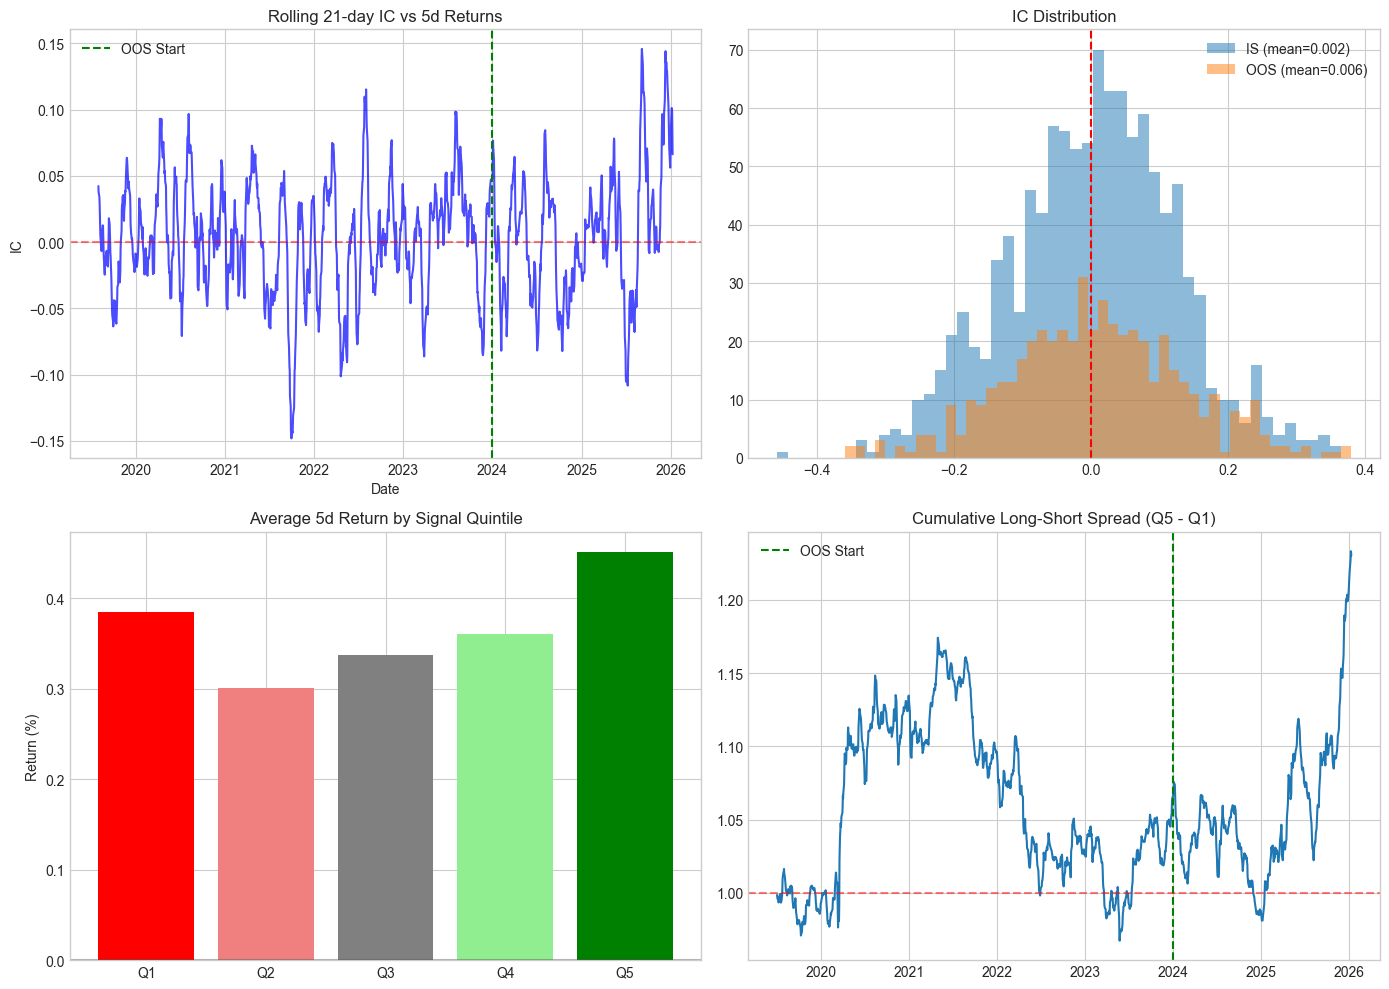


✅ Saved: c:\Users\ponna\OneDrive\Desktop\Precog Task\outputs\figures\stage2_v2\stage2_v2_evaluation.png


In [15]:
# ============================================================================
# VISUALIZATIONS
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Rolling IC
ax = axes[0, 0]
target_col = f'fwd_ret_{TARGET_HORIZON}d'
ic_series = final_output.groupby('date').apply(
    lambda g: spearmanr(g['signal_zscore'], g[target_col])[0] if len(g) > 5 and not g[target_col].isna().all() else np.nan
)
ic_rolling = ic_series.rolling(21).mean()
ax.plot(ic_rolling.index, ic_rolling.values, color='blue', alpha=0.7)
ax.axhline(0, color='red', linestyle='--', alpha=0.5)
ax.axvline(OOS_START, color='green', linestyle='--', label='OOS Start')
ax.set_title(f'Rolling 21-day IC vs {TARGET_HORIZON}d Returns')
ax.set_xlabel('Date')
ax.set_ylabel('IC')
ax.legend()

# 2. IC Distribution
ax = axes[0, 1]
is_ic = ic_series[ic_series.index <= IS_END].dropna()
oos_ic = ic_series[ic_series.index >= OOS_START].dropna()
ax.hist(is_ic, bins=50, alpha=0.5, label=f'IS (mean={is_ic.mean():.3f})')
ax.hist(oos_ic, bins=50, alpha=0.5, label=f'OOS (mean={oos_ic.mean():.3f})')
ax.axvline(0, color='red', linestyle='--')
ax.set_title('IC Distribution')
ax.legend()

# 3. Quintile returns
ax = axes[1, 0]
all_q_rets = final_output.copy()
all_q_rets['quintile'] = all_q_rets.groupby('date')['signal_zscore'].transform(
    lambda x: pd.qcut(x, 5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'], duplicates='drop')
)
q_means = all_q_rets.groupby('quintile')[target_col].mean() * 100
colors = ['red', 'lightcoral', 'gray', 'lightgreen', 'green']
ax.bar(q_means.index, q_means.values, color=colors)
ax.set_title(f'Average {TARGET_HORIZON}d Return by Signal Quintile')
ax.set_ylabel('Return (%)')
ax.axhline(0, color='black', linestyle='-', alpha=0.3)

# 4. Cumulative spread
ax = axes[1, 1]
q_daily = all_q_rets.groupby(['date', 'quintile'])[target_col].mean().unstack()
spread = q_daily['Q5'] - q_daily['Q1']
cum_spread = (1 + spread / TARGET_HORIZON).cumprod()  # Scale to daily
ax.plot(cum_spread.index, cum_spread.values)
ax.axvline(OOS_START, color='green', linestyle='--', label='OOS Start')
ax.axhline(1, color='red', linestyle='--', alpha=0.5)
ax.set_title('Cumulative Long-Short Spread (Q5 - Q1)')
ax.legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'stage2_v2_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Saved: {FIGURES_DIR / 'stage2_v2_evaluation.png'}")

## 2.6 Save Outputs

In [16]:
# ============================================================================
# SAVE OUTPUTS
# ============================================================================
print("Saving outputs...\n")

# Save predictions
final_output.to_parquet(OUTPUT_FILE, index=False)
print(f"✅ Predictions saved: {OUTPUT_FILE}")

# Save diagnostics
diagnostics = {
    'model': best_model,
    'params': best_params,
    'target': f'fwd_ret_{TARGET_HORIZON}d cross-sectional z-score',
    'is_metrics': is_metrics,
    'oos_metrics': oos_metrics,
    'feature_count': len(feature_cols),
    'timestamp': datetime.now().isoformat()
}

with open(MODEL_DIAGNOSTICS_FILE, 'w') as f:
    json.dump(diagnostics, f, indent=2, default=str)
print(f"✅ Diagnostics saved: {MODEL_DIAGNOSTICS_FILE}")

# Save model
model_path = MODELS_DIR / 'stage2_v2_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump({'model': final_model, 'scaler': scaler, 'features': feature_cols}, f)
print(f"✅ Model saved: {model_path}")

print("\n" + "="*70)
print(" STAGE 2 v2 COMPLETE")
print("="*70)
print(f"\nOutput file: {OUTPUT_FILE}")
print(f"Use this in Stage 3 backtesting!")

Saving outputs...

✅ Predictions saved: c:\Users\ponna\OneDrive\Desktop\Precog Task\data\processed\stage2_v2_predictions.parquet
✅ Diagnostics saved: c:\Users\ponna\OneDrive\Desktop\Precog Task\outputs\stage2_v2_diagnostics.json
✅ Model saved: c:\Users\ponna\OneDrive\Desktop\Precog Task\outputs\models\stage2_v2_model.pkl

 STAGE 2 v2 COMPLETE

Output file: c:\Users\ponna\OneDrive\Desktop\Precog Task\data\processed\stage2_v2_predictions.parquet
Use this in Stage 3 backtesting!
